# Compare 3 GY resampled daily QR (API) to weekly BLoomberg (excel)
100 stocks, from 2021-12-01 to 2021-01-31, loaded on 2024-09-05
* Excel weekly data (only friday): *QUANT_work..FUNDAMENTAL_DATA_STOCK_weekly_excel_test_100_stocks_v1*
* Excel daily data (weekends included): *QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_excel_test_100_stocks_v1*
* API daily data (NO weekend): *QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks_v1*

**Method resampling (weekly) of Bloomberg:**
* Weekly data (on Friday) of Bloomberg: last available value of the week (Monday to Sunday) will be assigned to be value of the week (noted friday) ***despite weekend***. *This is the principal difference with  QR method*

**Method of QR:**
* **Friday resample**
    * Reindex business daily data to full daily (including weekend)
    * Forwarfill with limit = 6 (week fill)
    * Keep only *Friday*

In this notebook, we identify 3 types of mismatch:

Parmi 4828 observations
* Type 1: BBG not NA, KC not NA, value different (differece >1%)): 0 observation (0%)
* Type 2: BBG not NA, KC NA: 135 observations (2.8%)
* Type 3: BBG NA, KC not NA: 76 observations (1.6%)

**Conclusion:**
* **we validate friday resample**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from dbtools.src.db_connexion import SqlConnector
import dbtools.src.get_repository as rep
from copy import deepcopy
import dbtools.src.dbtools_util as du
import matplotlib.pyplot as plt
import warnings
from pandas.tseries.offsets import BDay
pd.set_option('expand_frame_repr', False)
warnings.filterwarnings("ignore")
connector = SqlConnector()
con_mis = connector.connection()

In [3]:
FIELD = "eps_3gy"

In [4]:
## Load data
# daily of API
df_data_dict = pd.read_sql("""select attribute_id, name
                               from QUANT_work..FUNDAMENTAL_DATA_DICTIONARY""", con_mis)
df_data_dict = df_data_dict.set_index('attribute_id')['name']
df_daily_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks_v1', con_mis)
df_daily_db.DATE = pd.to_datetime(df_daily_db.DATE)
df_daily_db.attribute_id = df_daily_db.attribute_id.replace(df_data_dict)
df_daily_db = df_daily_db[df_daily_db.attribute_id==FIELD]

sec_common = df_daily_db.security_id.drop_duplicates()
dates = pd.date_range(df_daily_db.DATE.min(),df_daily_db.DATE.max())

df_daily_ts = df_daily_db.set_index(['DATE', 'security_id']).value.unstack()
df_daily_ts = df_daily_ts.reindex(index = dates, columns = sec_common)

## weekly from Excel
df_excel_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_weekly_excel_test_100_stocks_v1', con_mis)
df_excel_db.DATE = pd.to_datetime(df_excel_db.DATE)
df_excel_db.attribute_id = df_excel_db.attribute_id.replace(df_data_dict)
df_excel_db = df_excel_db[df_excel_db.attribute_id==FIELD]


df_excel_ts = df_excel_db.set_index(['DATE', 'security_id']).value.unstack()
df_excel_ts = df_excel_ts.reindex(columns = sec_common)
df_excel_ts = df_excel_ts[(df_excel_ts.index.weekday==4) & (df_excel_ts.index>df_excel_ts.index.min())]

In [5]:
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')
ticker = ticker.to_frame('fund_ticker')
ticker['td_id'] = rep.mapping_from_security(sec_common, 'prim_td_id')
## security_id dont l'année fiscale ne change pas en 01 janvier
sec_anom = [258, 11963, 15210, 15726, 17821, 18590, 18678, 38718, 38763, 47044, 1037829, 2632714, 2752161, 2757656, 2764531, 2907194, 2925627]
sec_anom = pd.Index(sec_anom)

## Comparison 3GY

In [6]:
## Sampling (weekly example)
# reindex daily
# week fill (with limit = 6 jours)
# Resample weekly (friday)
filled_df = du.fill_week_with_nans(df_daily_db, date_column='DATE')
df_ffill = du.custom_forward_fill(filled_df, date_column='DATE', field=FIELD, group_by_columns=['attribute_id','security_id'])
resampled_df_fridays = du.resample_data(df_ffill, date_column='DATE', mode='weekly', calendar_type='friday')
df_res_fri = resampled_df_fridays.set_index(['DATE', 'security_id']).value.unstack()
df_res_fri = df_res_fri[(df_res_fri.index>=df_excel_ts.index.min()) & (df_res_fri.index<=df_excel_ts.index.max())]

In [7]:
### Fonction  detail_diff: security_id, date, 
# output: dict security_id, date, value Bloom weekly, value resample KC, last value daily, last value daily date, nb days fill, last value week date
def detail_diff(df_diff, df_daily):
    df_tmp = df_diff.copy()
    df_tmp = df_tmp.rename(columns = {'excel':'BBG weekly',
                            'resampled':'resample KC'})
    df_tmp = df_tmp.reindex(columns = ['BBG weekly', 'resample KC', 'diff',
                                        'prev. value daily', 'prev. daily date',
                                        'prev. weekday', 'nb days ffill',
                                      'next value daily', 'next daily date', 'nb days bfill',])
    for date, security_id in df_diff.index:
        iloc = df_daily[security_id].index.get_loc(date)
        s = df_daily.iloc[:iloc+1][security_id].dropna()
        n = df_daily.iloc[iloc:][security_id].dropna()
        if s.empty:
            s = df_daily.iloc[[iloc]][security_id]
        if n.empty:
            n = df_daily.iloc[[iloc]][security_id]
        df_tmp.loc[(date, security_id),'prev. value daily'] = s.iloc[-1]
        df_tmp.loc[(date, security_id),'prev. weekday'] = s.index[-1].day_name()
        df_tmp.loc[(date, security_id),'prev. daily date'] = s.index[-1].date()
        df_tmp.loc[(date, security_id),'nb days ffill'] = (pd.to_datetime(date)-s.index[-1]).days
        

        df_tmp.loc[(date, security_id),'next value daily'] = n.iloc[0]
        df_tmp.loc[(date, security_id),'next daily date'] = n.index[0].date()
        df_tmp.loc[(date, security_id),'nb days bfill'] = (pd.to_datetime(n.index[0].date())-s.index[-1]).days
    df_tmp['prev. daily date'] = pd.to_datetime(df_tmp['prev. daily date']).dt.strftime('%Y.%m.%d')
    df_tmp['next daily date'] = pd.to_datetime(df_tmp['next daily date']).dt.strftime('%Y.%m.%d')
    df_tmp['nb days bfill'] = df_tmp['nb days bfill'].astype(int)
    df_tmp['nb days ffill'] = df_tmp['nb days ffill'].astype(int)
    return df_tmp

### Comparison resampled friday vs bloom
Parmi 4828 observations
* Type 1: 0 observation
* Type 2: 135 obs (BBG a des valeurs, KC est NA)
* Type 3: 76 obs BBG est NA, KC a des valeurs

In [8]:
df_diff_fri = pd.concat((df_excel_ts.stack(), df_res_fri.stack()), axis =1)
df_diff_fri.columns = ['excel', 'resampled']
df_diff_fri['diff'] = (df_diff_fri.resampled - df_diff_fri.excel)/df_diff_fri.resampled
df_diff_fri = detail_diff(df_diff_fri, df_daily_ts)
df_diff_fri.head()

BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
DATE       security_id                                                                                                                                                 
2021-12-10 25                5.058        5.058   0.0              5.058       2021.12.10        Friday              0             5.058      2021.12.10              0
           31                3.342        3.342   0.0              3.342       2021.12.09      Thursday              1             3.580      2022.01.03             25
           210              33.128       33.128   0.0             33.128       2021.12.07       Tuesday              3            33.143      2021.12.13              6
           258               5.644        5.644   0.0              5.644       2021.12.08     Wednesday              2             5.616      2021.12.13              5
           286               0.498        0.498   0.0              0.498       2021.12.10        Friday              0             0.498      2021.12.10              0

#### TYPE 1: absolute relative difference >1%
No observation

In [9]:
df_type1 = df_diff_fri[df_diff_fri['diff'].abs()>0.01].sort_values(by = ['security_id', 'DATE'])
df_type1

Empty DataFrame
Columns: [BBG weekly, resample KC, diff, prev. value daily, prev. daily date, prev. weekday, nb days ffill, next value daily, next daily date, nb days bfill]
Index: []

#### TYPE 2, 3: Difference is NA
* TYPE 2: BBG dispo mais KC NA
* TYPE 3: BBG NA mais KC dispo

In [25]:
df_diff_na  = df_diff_fri[df_diff_fri['diff'].isna() & (df_diff_fri['resample KC']!=0)].sort_values(by = ['security_id', 'DATE'])
df_diff_na = df_diff_na.reset_index()
df_diff_na.DATE = df_diff_na.DATE.dt.strftime('%Y.%m.%d')
df_type2 = df_diff_na[df_diff_na['resample KC'].isna()]
df_type3 = df_diff_na[df_diff_na['resample KC'].notna()]

df_type2['forwardfill'] = df_type2['BBG weekly']==df_type2['prev. value daily']
df_type2['backfill'] = (df_type2['BBG weekly']==df_type2['next value daily']) & (df_type2['BBG weekly']!=df_type2['prev. value daily'])
df_type2['interpolation'] = (df_type2['BBG weekly']!=df_type2['next value daily'])& (df_type2['BBG weekly']!=df_type2['prev. value daily'])

In [26]:
count_date = pd.concat((df_diff_na[['DATE']], df_diff_na[['BBG weekly', 'resample KC']].isna()), axis = 1).groupby('DATE').sum()
count_date['total'] = count_date[['BBG weekly', 'resample KC']].sum(axis =1)
count_date = count_date.sort_values('total')
count_date = count_date.rename(columns = {'BBG weekly': 'Type 3', 'resample KC':'Type 2'})

count_type2 = df_type2[['DATE','forwardfill', 'backfill', 'interpolation']].groupby('DATE').sum()
count_type2['total'] = count_type2[['forwardfill', 'backfill', 'interpolation']].sum(axis =1)
count_type2 = count_type2.sort_values('total')

count_sec = pd.concat((df_diff_na[['security_id']], df_diff_na[['BBG weekly', 'resample KC']].isna()), axis = 1).groupby('security_id').sum()
count_sec['total'] = count_sec[['BBG weekly', 'resample KC']].sum(axis =1)
count_sec = count_sec.sort_values('total')
count_sec = count_sec.rename(index =ticker.fund_ticker, columns = {'BBG weekly': 'Type 3', 'resample KC':'Type 2'})

In [27]:
print('---- Error type 2: -------\n', count_type2.sum())
print('---- Error type 3: ------', df_type3.shape[0])

---- Error type 2: -------
 forwardfill       15
backfill         115
interpolation      5
total            135
dtype: int64
---- Error type 3: ------ 76


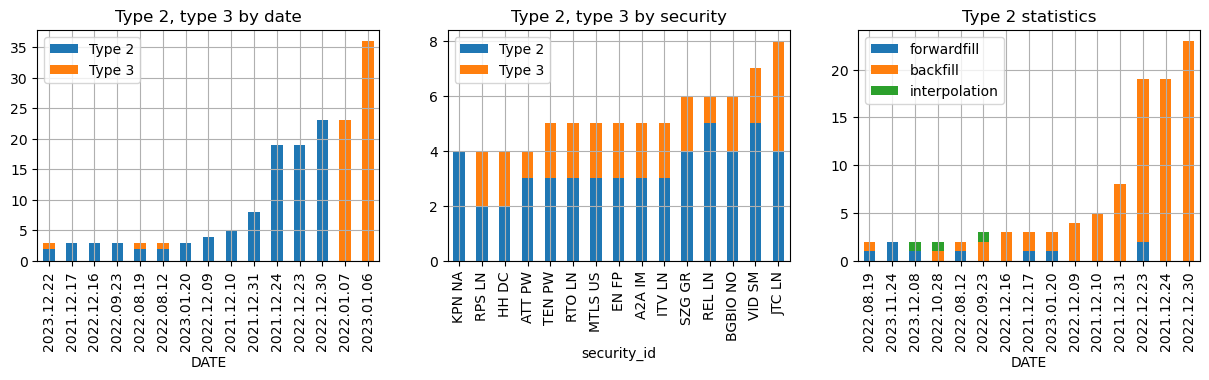

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
a = count_date.iloc[-15:][['Type 2', 'Type 3']]
a.plot.bar(stacked = True, ax=ax[0], title = 'Type 2, type 3 by date')

b = count_sec.iloc[-15:][['Type 2', 'Type 3']]
b.plot.bar(stacked = True, ax = ax[1], title = 'Type 2, type 3 by security')

c = count_type2.iloc[-15:][['forwardfill', 'backfill', 'interpolation']]
c.plot.bar(stacked = True, ax=ax[2], title = 'Type 2 statistics')
[ax[i].grid() for i in range(len(ax))]
plt.show()
df_type2 = df_type2.drop(columns = ['forwardfill', 'backfill', 'interpolation'])

##### Type 2

In [29]:
print("On a l'impression que Bloomberg utilise forward fill (> 1 semaine)")
df_type2[df_type2['BBG weekly']==df_type2['prev. value daily']]

On a l'impression que Bloomberg utilise forward fill (> 1 semaine)


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
5    2023.08.18           31       4.128          NaN   NaN              4.128       2023.08.11        Friday              7             4.128      2023.08.28             17
10   2024.01.19          210      33.881          NaN   NaN             33.881       2024.01.08        Monday             11            33.881      2024.01.29             21
21   2023.12.08          436       1.178          NaN   NaN              1.178       2023.11.27        Monday             11             1.178      2023.12.11             14
38   2022.03.11         8087       1.179          NaN   NaN              1.179       2022.03.04        Friday              7             1.179      2022.03.21             17
60   2023.01.20        12594       0.130          NaN   NaN              0.130       2023.01.11     Wednesday              9             0.130      2023.02.20             40
78   2023.12.01        19556       8.055          NaN   NaN              8.055       2023.11.24        Friday              7             8.055      2023.12.11             17
104  2022.12.23       219147       0.106          NaN   NaN              0.106       2022.12.15      Thursday              8             0.118      2023.01.02             18
124  2022.12.23       658971       6.375          NaN   NaN              6.375       2022.12.13       Tuesday             10             7.800      2023.04.24            132
131  2022.08.19      1298078       0.483          NaN   NaN              0.483       2022.08.08        Monday             11             0.483      2022.08.29             21
135  2022.09.16      2632714       0.350          NaN   NaN              0.350       2022.09.07     Wednesday              9             0.350      2022.10.03             26
142  2023.11.24      2732114       0.270          NaN   NaN              0.270       2023.11.13        Monday             11             0.350      2024.01.01             49
150  2022.08.12      2743482       0.126          NaN   NaN              0.126       2022.08.05        Friday              7             0.126      2022.08.15             10
162  2023.11.24      2764505      -0.975          NaN   NaN             -0.975       2023.11.13        Monday             11               NaN      2023.11.24             11
175  2023.11.10      2825493       0.458          NaN   NaN              0.458       2023.11.02      Thursday              8             0.458      2023.11.13             11
186  2021.12.17      2907194       0.089          NaN   NaN              0.089       2021.12.10        Friday              7             0.089      2022.01.03             24

In [33]:
print("On a l'impression que Bloomberg utilise backfill")
df_type22 = df_type2[(df_type2['BBG weekly']==df_type2['next value daily']) & (df_type2['BBG weekly']!=df_type2['prev. value daily'])]
df_type22

On a l'impression que Bloomberg utilise backfill


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
0    2021.12.17           25       5.490          NaN   NaN              5.058       2021.12.10        Friday              7             5.490      2022.01.03             24
2    2021.12.17           31       3.580          NaN   NaN              3.342       2021.12.09      Thursday              8             3.580      2022.01.03             25
7    2021.12.31           89      15.160          NaN   NaN             14.125       2021.12.21       Tuesday             10            15.160      2022.01.03             13
8    2022.12.30          210      40.200          NaN   NaN             37.238       2022.12.23        Friday              7            40.200      2023.01.02             10
9    2023.01.20          210      39.518          NaN   NaN             39.619       2023.01.13        Friday              7            39.518      2023.01.30             17
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
201  2022.12.02      3012537       0.750          NaN   NaN              0.503       2022.11.25        Friday              7             0.750      2023.01.02             38
203  2021.12.24      3031213       0.670          NaN   NaN              0.583       2021.12.14       Tuesday             10             0.670      2022.01.03             20
205  2022.12.30      3031213       0.560          NaN   NaN              0.460       2022.12.19        Monday             11             0.560      2023.01.02             14
207  2022.12.30     10172537       3.790          NaN   NaN              3.323       2022.12.22      Thursday              8             3.790      2023.01.02             11
209  2022.07.15     10173378       1.340          NaN   NaN              1.360       2022.07.08        Friday              7             1.340      2022.08.08             31

[115 rows x 12 columns]

In [35]:
print("Pour les backfill, souvent BBG utilise la valeur de la prochaine année fiscale pour filler la fin le l'année précécente, on voit bien le saut (pct_jump)")
df_bffill = df_type22[(df_type22['next daily date'].isin(['2024.01.01', '2023.01.02', '2022.01.03'])) & (df_type22.DATE.str[5:7]=='12')]
df_bffill['pct_jump'] = ((df_bffill['BBG weekly'] - df_bffill['prev. value daily'])/df_bffill['prev. value daily']*100).round(2)
df_bffill.sort_values(by = ['security_id', 'next daily date'])

Pour les backfill, souvent BBG utilise la valeur de la prochaine année fiscale pour filler la fin le l'année précécente, on voit bien le saut (pct_jump)


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill  pct_jump
0    2021.12.17           25       5.490          NaN   NaN              5.058       2021.12.10        Friday              7             5.490      2022.01.03             24      8.54
2    2021.12.17           31       3.580          NaN   NaN              3.342       2021.12.09      Thursday              8             3.580      2022.01.03             25      7.12
7    2021.12.31           89      15.160          NaN   NaN             14.125       2021.12.21       Tuesday             10            15.160      2022.01.03             13      7.33
8    2022.12.30          210      40.200          NaN   NaN             37.238       2022.12.23        Friday              7            40.200      2023.01.02             10      7.95
11   2022.12.23          286       1.660          NaN   NaN              2.169       2022.12.12        Monday             11             1.660      2023.01.02             21    -23.47
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...       ...
199  2022.12.23      3010803       0.435          NaN   NaN              0.243       2022.12.13       Tuesday             10             0.435      2023.01.02             20     79.01
201  2022.12.02      3012537       0.750          NaN   NaN              0.503       2022.11.25        Friday              7             0.750      2023.01.02             38     49.11
203  2021.12.24      3031213       0.670          NaN   NaN              0.583       2021.12.14       Tuesday             10             0.670      2022.01.03             20     14.92
205  2022.12.30      3031213       0.560          NaN   NaN              0.460       2022.12.19        Monday             11             0.560      2023.01.02             14     21.74
207  2022.12.30     10172537       3.790          NaN   NaN              3.323       2022.12.22      Thursday              8             3.790      2023.01.02             11     14.05

[80 rows x 13 columns]

In [14]:
print("On a l'impression que Bloomberg utilise interpolation par les valeur avant et après. Il y a bcp de valeur de fin d'année")
df_type2[(df_type2['BBG weekly']!=df_type2['next value daily'])& (df_type2['BBG weekly']!=df_type2['prev. value daily'])]

On a l'impression que Bloomberg utilise interpolation par les valeur avant et après. Il y a bcp de valeur de fin d'année


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
4    2022.10.28           31       3.632          NaN   NaN              3.629       2022.10.20      Thursday              8             3.607      2022.10.31             11
48   2023.06.16        11701       0.223          NaN   NaN              0.222       2023.06.09        Friday              7             0.219      2023.06.19             10
75   2023.12.22        19072       1.549          NaN   NaN              1.564       2023.12.12       Tuesday             10             1.748      2024.01.01             20
166  2022.09.23      2765679      -4.127          NaN   NaN             -4.239       2022.09.12        Monday             11            -4.124      2022.11.28             77
181  2023.12.08      2833331      10.088          NaN   NaN              9.283       2023.12.01        Friday              7            10.120      2023.12.11             10

##### Type 3

In [15]:
df_type3

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
1    2022.01.07           25         NaN        5.490   NaN              5.490       2022.01.03        Monday              4             5.340      2022.02.16             44
3    2022.01.07           31         NaN        3.580   NaN              3.580       2022.01.03        Monday              4             3.548      2022.01.14             11
6    2023.09.01           31         NaN        4.128   NaN              4.128       2023.08.28        Monday              4             4.128      2023.09.07             10
13   2022.01.07          359         NaN        6.049   NaN              6.049       2022.01.03        Monday              4             6.053      2022.01.21             18
18   2023.01.06          359         NaN        5.804   NaN              5.804       2023.01.02        Monday              4             5.883      2023.01.17             15
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
202  2023.01.06      3012537         NaN        0.750   NaN              0.750       2023.01.02        Monday              4             0.745      2023.01.25             23
204  2022.01.07      3031213         NaN        0.670   NaN              0.670       2022.01.03        Monday              4             0.710      2022.01.20             17
206  2023.01.06      3031213         NaN        0.560   NaN              0.560       2023.01.02        Monday              4             0.540      2023.03.29             86
208  2023.01.06     10172537         NaN        3.790   NaN              3.790       2023.01.02        Monday              4             3.550      2023.02.16             45
210  2022.08.12     10173378         NaN        1.340   NaN              1.340       2022.08.08        Monday              4             1.265      2022.10.03             56

[76 rows x 12 columns]

In [16]:
df_type3.DATE.value_counts()
print(df_type3['prev. weekday'].unique())
df_type3.DATE.value_counts().to_frame().T

['Monday']


DATE   2023.01.06  2022.01.07  2023.12.15  2023.04.07  2022.07.29  2023.12.29  2022.07.08  2022.08.19  2023.09.01  2022.05.06  2022.04.01  2023.08.11  2022.06.24  2022.09.30  2023.07.14  2023.12.22  2022.08.12
count          36          23           2           2           1           1           1           1           1           1           1           1           1           1           1           1           1

# End of notebook

## Draft

In [17]:
df_type2[df_type2['BBG weekly']==df_type2['prev. value daily']]

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
5    2023.08.18           31       4.128          NaN   NaN              4.128       2023.08.11        Friday              7             4.128      2023.08.28             17
10   2024.01.19          210      33.881          NaN   NaN             33.881       2024.01.08        Monday             11            33.881      2024.01.29             21
21   2023.12.08          436       1.178          NaN   NaN              1.178       2023.11.27        Monday             11             1.178      2023.12.11             14
38   2022.03.11         8087       1.179          NaN   NaN              1.179       2022.03.04        Friday              7             1.179      2022.03.21             17
60   2023.01.20        12594       0.130          NaN   NaN              0.130       2023.01.11     Wednesday              9             0.130      2023.02.20             40
78   2023.12.01        19556       8.055          NaN   NaN              8.055       2023.11.24        Friday              7             8.055      2023.12.11             17
104  2022.12.23       219147       0.106          NaN   NaN              0.106       2022.12.15      Thursday              8             0.118      2023.01.02             18
124  2022.12.23       658971       6.375          NaN   NaN              6.375       2022.12.13       Tuesday             10             7.800      2023.04.24            132
131  2022.08.19      1298078       0.483          NaN   NaN              0.483       2022.08.08        Monday             11             0.483      2022.08.29             21
135  2022.09.16      2632714       0.350          NaN   NaN              0.350       2022.09.07     Wednesday              9             0.350      2022.10.03             26
142  2023.11.24      2732114       0.270          NaN   NaN              0.270       2023.11.13        Monday             11             0.350      2024.01.01             49
150  2022.08.12      2743482       0.126          NaN   NaN              0.126       2022.08.05        Friday              7             0.126      2022.08.15             10
162  2023.11.24      2764505      -0.975          NaN   NaN             -0.975       2023.11.13        Monday             11               NaN      2023.11.24             11
175  2023.11.10      2825493       0.458          NaN   NaN              0.458       2023.11.02      Thursday              8             0.458      2023.11.13             11
186  2021.12.17      2907194       0.089          NaN   NaN              0.089       2021.12.10        Friday              7             0.089      2022.01.03             24

In [18]:
df_daily_ts[25].dropna()

2021-12-01    5.058
2021-12-03    5.058
2021-12-10    5.058
2022-01-03    5.490
2022-02-16    5.340
              ...  
2023-11-27    6.462
2023-12-04    6.462
2023-12-07    6.491
2024-01-01    6.995
2024-01-18    7.115
Name: 25, Length: 88, dtype: float64

In [19]:
df_diff_fri

BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
DATE       security_id                                                                                                                                                 
2021-12-10 25                5.058        5.058   0.0              5.058       2021.12.10        Friday              0             5.058      2021.12.10              0
           31                3.342        3.342   0.0              3.342       2021.12.09      Thursday              1             3.580      2022.01.03             25
           210              33.128       33.128   0.0             33.128       2021.12.07       Tuesday              3            33.143      2021.12.13              6
           258               5.644        5.644   0.0              5.644       2021.12.08     Wednesday              2             5.616      2021.12.13              5
           286               0.498        0.498   0.0              0.498       2021.12.10        Friday              0             0.498      2021.12.10              0
...                            ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
2023-09-01 31                  NaN        4.128   NaN              4.128       2023.08.28        Monday              4             4.128      2023.09.07             10
2023-12-15 436                 NaN        1.178   NaN              1.178       2023.12.11        Monday              4             1.178      2023.12.19              8
           19556               NaN        8.055   NaN              8.055       2023.12.11        Monday              4            14.850      2024.01.01             21
2023-12-22 2825493             NaN        0.458   NaN              0.458       2023.12.18        Monday              4             0.414      2024.01.01             14
2023-12-29 11963               NaN       11.396   NaN             11.396       2023.12.25        Monday              4            11.441      2024.01.02              8

[4828 rows x 10 columns]

In [20]:
df_type2

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
0    2021.12.17           25       5.490          NaN   NaN              5.058       2021.12.10        Friday              7             5.490      2022.01.03             24
2    2021.12.17           31       3.580          NaN   NaN              3.342       2021.12.09      Thursday              8             3.580      2022.01.03             25
4    2022.10.28           31       3.632          NaN   NaN              3.629       2022.10.20      Thursday              8             3.607      2022.10.31             11
5    2023.08.18           31       4.128          NaN   NaN              4.128       2023.08.11        Friday              7             4.128      2023.08.28             17
7    2021.12.31           89      15.160          NaN   NaN             14.125       2021.12.21       Tuesday             10            15.160      2022.01.03             13
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
201  2022.12.02      3012537       0.750          NaN   NaN              0.503       2022.11.25        Friday              7             0.750      2023.01.02             38
203  2021.12.24      3031213       0.670          NaN   NaN              0.583       2021.12.14       Tuesday             10             0.670      2022.01.03             20
205  2022.12.30      3031213       0.560          NaN   NaN              0.460       2022.12.19        Monday             11             0.560      2023.01.02             14
207  2022.12.30     10172537       3.790          NaN   NaN              3.323       2022.12.22      Thursday              8             3.790      2023.01.02             11
209  2022.07.15     10173378       1.340          NaN   NaN              1.360       2022.07.08        Friday              7             1.340      2022.08.08             31

[135 rows x 12 columns]

#### stocks dont 1GY sont dispo le 1er janvier, début l'année fiscale, même si un weekend
Tous les stocks dont l'année fiscale commence en janvier ont des données 1GY

In [21]:
df_fy_23 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20221228', '20230105'))]
df_fy_23 = df_fy_23.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

df_fy_22 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20211228', '20220105'))]
df_fy_22 = df_fy_22.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

In [ ]:
df_fy_22[df_fy_22['2022-01-01'].isna()]

#### Si les données de 1GY début l'AF est remplies par 2GY de l'année précédente: NON

In [ ]:
df = pd.concat((df_1gy_daily_ts.loc['2023-01-01'].to_frame('1GY_20230101'),
                df_2gy_daily_ts.loc['2022-01-01'].to_frame('2GY_20220101')), axis = 1)
df = df[~df.index.isin(sec_anom)]
df['is_filled'] = df['1GY_20230101'] == df['2GY_20220101']
df[df.is_filled]

In [ ]:
df_type2